In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from extinctions import *
from preprocessing import *
from plotting_parameters import *

In [6]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)
endmember_labels = ["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "HHb", "HbO$_2$", "water", "lipids", "a'"]

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
scatter_simple = (band_centers/500)**(-1.2)


M_scatter_orig = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb, hbo2, water, fat, scatter_simple)).T
M_scatter_orig_smooth = smooth_spectral(M_scatter_orig.T,5).T


spectra_folder = "../mc_sim/spectra_mc/"

hb_mc = np.loadtxt(spectra_folder + "m_hhb_50.txt")
hbo2_mc = np.loadtxt(spectra_folder + "m_hbo2_50.txt")
cyt_c_ox_mc = np.loadtxt(spectra_folder + "m_cyt_c_ox_20.txt")
cyt_c_red_mc = np.loadtxt(spectra_folder + "m_cyt_c_red_20.txt")
cyt_b_ox_mc = np.loadtxt(spectra_folder + "m_cyt_b_ox_20.txt")
cyt_b_red_mc = np.loadtxt(spectra_folder + "m_cyt_b_red_20.txt")
cyt_oxi_ox_mc = np.loadtxt(spectra_folder + "m_cyt_oxi_ox_20.txt")
cyt_oxi_red_mc = np.loadtxt(spectra_folder + "m_cyt_oxi_red_20.txt")
scatter_mc = np.loadtxt(spectra_folder + "m_scatter_40.txt")
water_mc = np.loadtxt(spectra_folder + "m_water_200.txt")
fat_mc = np.loadtxt(spectra_folder + "m_fat_200.txt")

M_mc = np.vstack((cyt_c_ox_mc, cyt_c_red_mc, cyt_b_ox_mc, cyt_b_red_mc, cyt_oxi_ox_mc, cyt_oxi_red_mc, hb_mc, hbo2_mc, water_mc, fat_mc, scatter_mc)).T
M_mc_smooth = smooth_spectral(M_mc.T,5).T

M_hb = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb_mc, hbo2_mc, water, fat, scatter_simple)).T
M_hb = smooth_spectral(M_hb.T,5).T

In [17]:
def icem(spectr, t, lmda=0, labels=None, device='cpu', Rinv=None):
    '''
    Improved constrained energy minimization (ICEM) algorithm.
    input:
        spectr: image to unmix, shape (...,k) where k is the number of bands and ... are the spatial or time dimensions
        t: endmember to unmix, shape (k,)
        lmda: regularization parameter, float
    output:
        heatmap, np.array
    '''
    # ignore pixels that are not tissue
    spectr_tissue = spectr
    if labels is not None:
        spectr_tissue = spectr[labels != 4]

    was_numpy = isinstance(spectr, np.ndarray)
    spectr = torch.tensor(spectr, device=device).float()
    spectr_tissue = torch.tensor(spectr_tissue, device=device).float()
    t = torch.tensor(t, device=device).float()

    input_shape = spectr.shape
    M = spectr_tissue.reshape(-1, input_shape[-1])
    M_all = spectr.reshape(-1, input_shape[-1])

    N, p = M.shape
    if Rinv is None:
        R_hat = torch.mm(M.T, M) / N + lmda * torch.eye(p, device=device)
        Rinv = torch.inverse(R_hat)
    t_Rinv = torch.mv(Rinv.T, t)
    denom = torch.dot(t, t_Rinv)
    y = torch.mv(M_all, t_Rinv) / denom

    if was_numpy:
        y =  y.cpu().numpy()

    return y.reshape(input_shape[:-1]), Rinv

In [15]:
def generate_heatmaps(absorbance, reference_spectrum, labels, folder):
    n = M_scatter_orig_smooth.shape[1]
    l, m = absorbance.shape[:2]
    diff_absorbance = absorbance - reference_spectrum[None,None,:]

    heatmaps_osp = np.zeros((l,m,n))
    heatmaps_osp_diff = np.zeros((l,m,n))
    heatmaps_osp_diff_mc = np.zeros((l,m,n))
    heatmaps_icem = np.zeros((l,m,n))
    heatmaps_icem_diff = np.zeros((l,m,n))
    heatmaps_icem_diff_mc = np.zeros((l,m,n))
    for i in range(n):
        endmembers_remove = np.delete(M_scatter_orig_smooth, i, axis=1).T
        endmember_target = M_scatter_orig_smooth[:,i]
        heatmaps_osp[:,:,i] = osp(absorbance, endmembers_remove, endmember_target)
        heatmaps_osp_diff[:,:,i] = osp(diff_absorbance, endmembers_remove, endmember_target)

        heatmaps_icem[:,:,i], Rinv_abs = icem(absorbance, endmember_target, 1, labels=labels)
        heatmaps_icem_diff[:,:,i], Rinv_diff_abs = icem(diff_absorbance, endmember_target, 1, labels=labels)


        endmembers_remove = np.delete(M_mc_smooth, i, axis=1).T
        endmember_target = M_mc_smooth[:,i]
        heatmaps_osp_diff_mc[:,:,i] = osp(diff_absorbance, endmembers_remove, endmember_target)
        heatmaps_icem_diff_mc[:,:,i], _ = icem(diff_absorbance, endmember_target, 1, labels=labels)

    if not os.path.exists(folder):
        os.makedirs(folder)
    np.save(folder + "heatmaps_osp.npy", heatmaps_osp)
    np.save(folder + "heatmaps_osp_diff.npy", heatmaps_osp_diff)
    np.save(folder + "heatmaps_osp_diff_mc.npy", heatmaps_osp_diff_mc)
    np.save(folder + "heatmaps_icem.npy", heatmaps_icem)
    np.save(folder + "heatmaps_icem_diff.npy", heatmaps_icem_diff)
    np.save(folder + "heatmaps_icem_diff_mc.npy", heatmaps_icem_diff_mc)

    return heatmaps_osp, heatmaps_osp_diff, heatmaps_osp_diff_mc, heatmaps_icem, heatmaps_icem_diff, heatmaps_icem_diff_mc

### Own labels

008-01
008-02
010-03
012-01
012-02
015-01
016-04
016-05
017-01
020-01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


039-01


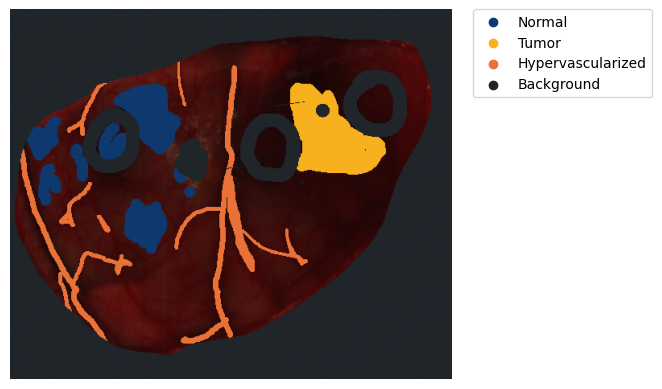

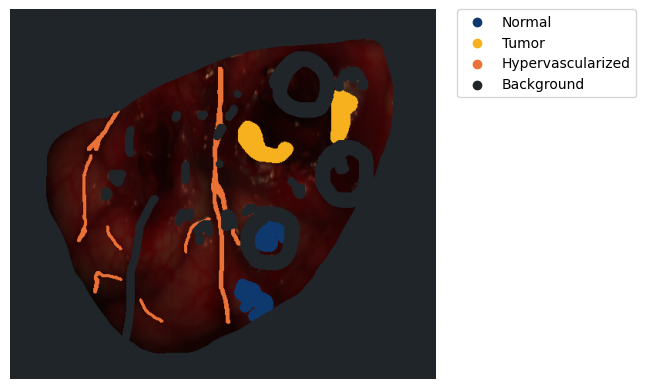

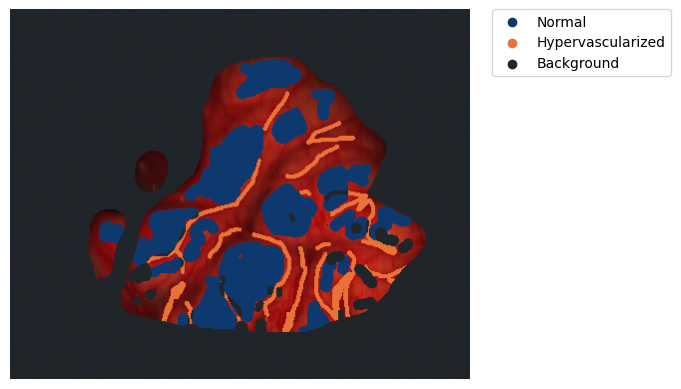

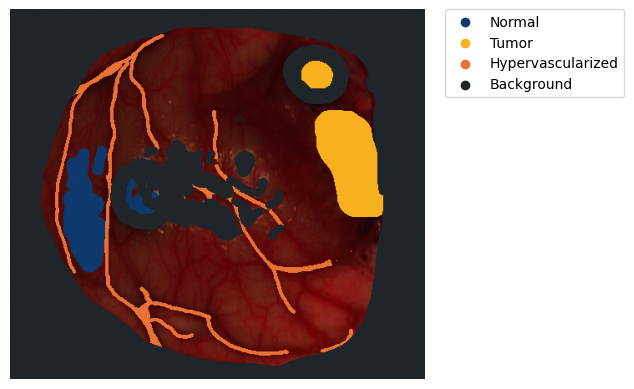

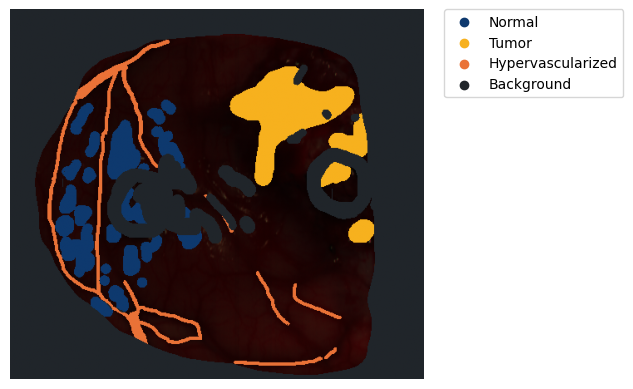

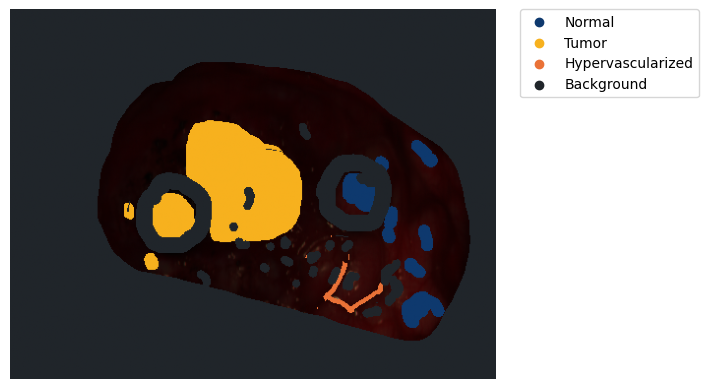

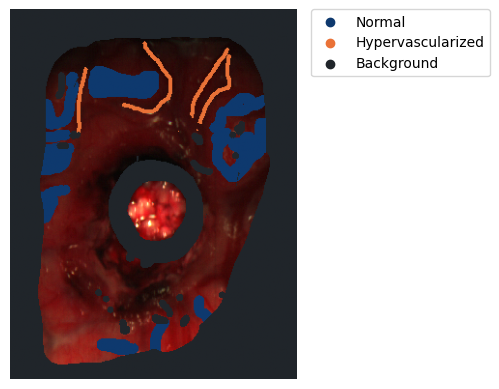

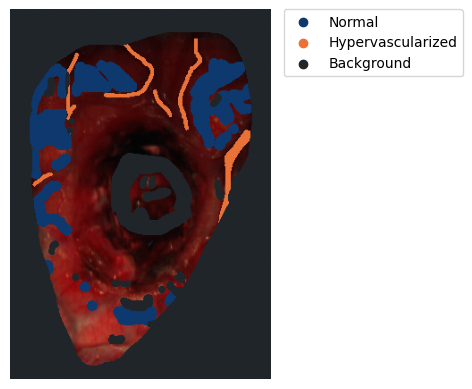

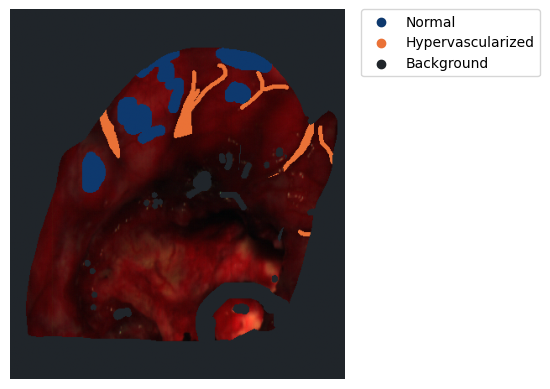

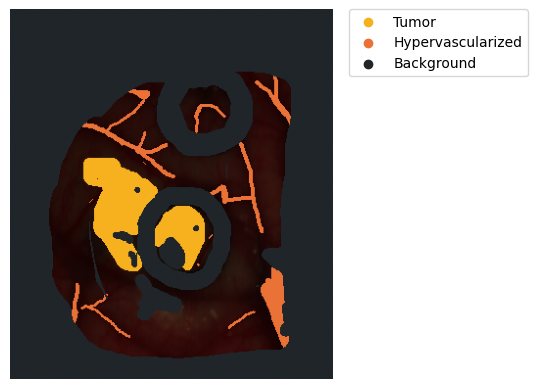

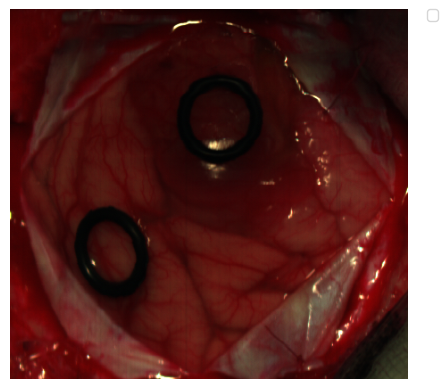

In [19]:
class_labels = ["Not labled", "Normal", "Tumor", "Hypervascularized", "Background"]
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)
gradeIVpatients = ["008-01", "008-02", "010-03", "012-01", "012-02", "015-01", "016-04", "016-05", "017-01", "020-01", "039-01"]

raw_data_all = []
preprocessed_data_all = []
labels_all = []
heatmapts_osp_all = []
heatmapts_osp_diff_all = []
heatmapts_osp_diff_mc_all = []
heatmapts_icem_all = []
heatmapts_icem_diff_all = []
heatmapts_icem_diff_mc_all = []

for patient in gradeIVpatients:
    data_folder = f"../../datasets/helicoid/{patient}"
    print(patient)

    # Load the sp data
    img = sp.open_image(data_folder + "/raw.hdr")
    white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
    dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
    labels = np.load(data_folder + "/labels.npy")
    gt_map = sp.open_image(data_folder + "/gtMap.hdr")

    plot_img(img, labels, class_labels, class_colors=["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_1])

    # preprocessing
    img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
    white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
    dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
    img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
    img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=(0,1), ord=1, keepdims=True)
    img_smooth = smooth_spectral(img_calib_norm, 5)
    absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

    # select random spectrum from normal class
    np.random.seed(1)
    normal_idx = np.argwhere(gt_map.asarray() == 1)
    random_idx = np.random.choice(normal_idx.shape[0])
    reference_spectrum = absorbance[normal_idx[random_idx,0], normal_idx[random_idx,1], :]

    heatmaps_osp, heatmaps_osp_diff, heatmaps_osp_diff_mc, heatmaps_icem, heatmaps_icem_diff, heatmaps_icem_diff_mc = generate_heatmaps(absorbance, reference_spectrum, labels, f"./{patient}/")

    # k = absorbance.shape[-1]
    # n = heatmaps_osp.shape[-1]

    raw_data_all.append(img_interp[(labels != 0) & (labels != 4)])
    preprocessed_data_all.append(absorbance[(labels != 0) & (labels != 4)])
    labels_all.append(labels[(labels != 0) & (labels != 4)])
    heatmapts_osp_all.append(heatmaps_osp[(labels != 0) & (labels != 4)])
    heatmapts_osp_diff_all.append(heatmaps_osp_diff[(labels != 0) & (labels != 4)])
    heatmapts_osp_diff_mc_all.append(heatmaps_osp_diff_mc[(labels != 0) & (labels != 4)])
    heatmapts_icem_all.append(heatmaps_icem[(labels != 0) & (labels != 4)])
    heatmapts_icem_diff_all.append(heatmaps_icem_diff[(labels != 0) & (labels != 4)])
    heatmapts_icem_diff_mc_all.append(heatmaps_icem_diff_mc[(labels != 0) & (labels != 4)])

raw_data_all = np.vstack(raw_data_all)
preprocessed_data_all = np.vstack(preprocessed_data_all)
labels_all = np.concatenate(labels_all)
heatmapts_osp_all = np.vstack(heatmapts_osp_all)
heatmapts_osp_diff_all = np.vstack(heatmapts_osp_diff_all)
heatmapts_osp_diff_mc_all = np.vstack(heatmapts_osp_diff_mc_all)
heatmapts_icem_all = np.vstack(heatmapts_icem_all)
heatmapts_icem_diff_all = np.vstack(heatmapts_icem_diff_all)
heatmapts_icem_diff_mc_all = np.vstack(heatmapts_icem_diff_mc_all)

In [15]:
folder = "./normal_tumor_blood/"
if not os.path.exists(folder):
    os.makedirs(folder)
np.save(folder + "raw_data_all.npy", raw_data_all)
np.save(folder + "preprocessed_data_all.npy", preprocessed_data_all)
np.save(folder + "labels_all.npy", labels_all)
np.save(folder + "heatmapts_osp_all.npy", heatmapts_osp_all)
np.save(folder + "heatmapts_osp_diff_all.npy", heatmapts_osp_diff_all)
np.save(folder + "heatmapts_osp_diff_mc_all.npy", heatmapts_osp_diff_mc_all)
np.save(folder + "heatmapts_icem_all.npy", heatmapts_icem_all)
np.save(folder + "heatmapts_icem_diff_all.npy", heatmapts_icem_diff_all)
np.save(folder + "heatmapts_icem_diff_mc_all.npy", heatmapts_icem_diff_mc_all)


# # # load the data
# class_labels = ["Not labled", "Normal", "Tumor", "Hypervascularized", "Background"]
# raw_data_all = np.load(folder + "raw_data_all.npy")
# preprocessed_data_all = np.load(folder + "preprocessed_data_all.npy")
# labels_all = np.load(folder + "labels_all.npy")
# heatmapts_osp_all = np.load(folder + "heatmapts_osp_all.npy")
# heatmapts_osp_diff_all = np.load(folder + "heatmapts_osp_diff_all.npy")
# heatmapts_osp_diff_mc_all = np.load(folder + "heatmapts_osp_diff_mc_all.npy")
# heatmapts_icem_all = np.load(folder + "heatmapts_icem_all.npy")
# heatmapts_icem_diff_all = np.load(folder + "heatmapts_icem_diff_all.npy")
# heatmapts_icem_diff_mc_all = np.load(folder + "heatmapts_icem_diff_mc_all.npy")

In [16]:
# get class ratios
normal_ratio = np.sum(labels_all == 1) / labels_all.shape[0]
tumor_ratio = np.sum(labels_all == 2) / labels_all.shape[0]
blood_ratio = np.sum(labels_all == 3) / labels_all.shape[0]

print(f"Normal ratio: {normal_ratio:.2f}, Tumor ratio: {tumor_ratio:.2f}, Blood ratio: {blood_ratio:.2f}")

[3 3 3 ... 3 3 3]
Normal ratio: 0.47, Tumor ratio: 0.29, Blood ratio: 0.25


### T-SNE

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='t-SNE component 1', ylabel='t-SNE component 2'>)

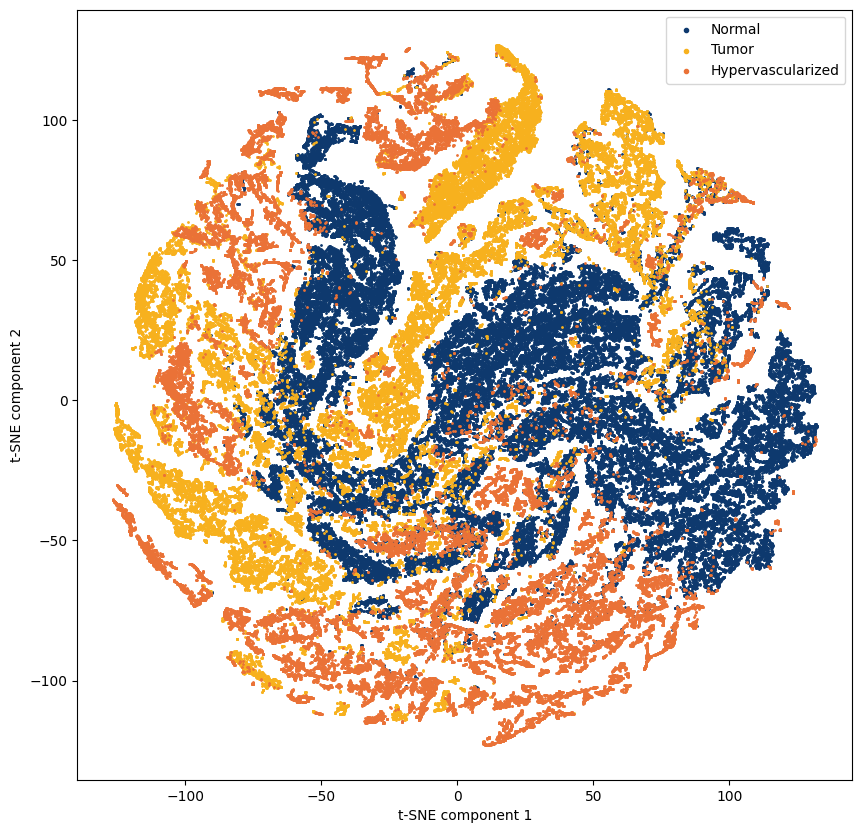

In [5]:
fig, ax = plot_tsne(raw_data_all, labels_all, class_labels, figsize=(10,10), mode="all")
ax.set_title("Raw data")
fig, ax = plot_tsne(preprocessed_data_all, labels_all, class_labels, figsize=(10,10), mode="all")
ax.set_title("Preprocessed data")
fig, ax = plot_tsne(heatmapts_osp_all, labels_all, class_labels, figsize=(10,10), mode="all")
ax.set_title("OSP")
fig, ax = plot_tsne(heatmapts_osp_diff_all, labels_all, class_labels, figsize=(10,10), mode="all")
ax.set_title("OSP diff")
fig, ax = plot_tsne(heatmapts_osp_diff_mc_all, labels_all, class_labels, figsize=(10,10), mode="all")
ax.set_title("OSP diff mc")
fig, ax = plot_tsne(heatmapts_icem_all, labels_all, class_labels, figsize=(10,10), mode="all")
ax.set_title("ICEM")
fig, ax = plot_tsne(heatmapts_icem_diff_all, labels_all, class_labels, figsize=(10,10), mode="all")
ax.set_title("ICEM diff")

In [5]:
def clip_rescale(heatmaps, lower_clip=None, upper_clip=None, center=None):
    if lower_clip is None:
        lower_clip = np.percentile(heatmaps, 0.1, axis=0, keepdims=True)
    if upper_clip is None:
        upper_clip = np.percentile(heatmaps, 99.9, axis=0, keepdims=True)
    heatmaps = np.clip(heatmaps, lower_clip, upper_clip)
    heatmaps = heatmaps / (upper_clip - lower_clip)
    if center is None:
        center = np.percentile(heatmaps, 50, axis=0, keepdims=True)
    heatmaps = heatmaps - center + 0.5
    return heatmaps, lower_clip, upper_clip, center

def plot_map_dist(heatmaps, endmember_labels):
    n = heatmaps.shape[1]
    # plt.figure()
    # for i in range(n):
    #     plt.hist(heatmaps[:,i], bins=100, alpha=0.5, label=endmember_labels[i])
    #     plt.legend(endmember_labels, loc='center left', bbox_to_anchor=(1, 0.5))
    fig, axs = plt.subplots(1, n, figsize=(n*3, 3))
    for i in range(n):
        axs[i].hist(heatmaps[:,i], bins=100, alpha=0.5)
        axs[i].set_title(endmember_labels[i])

### OSP

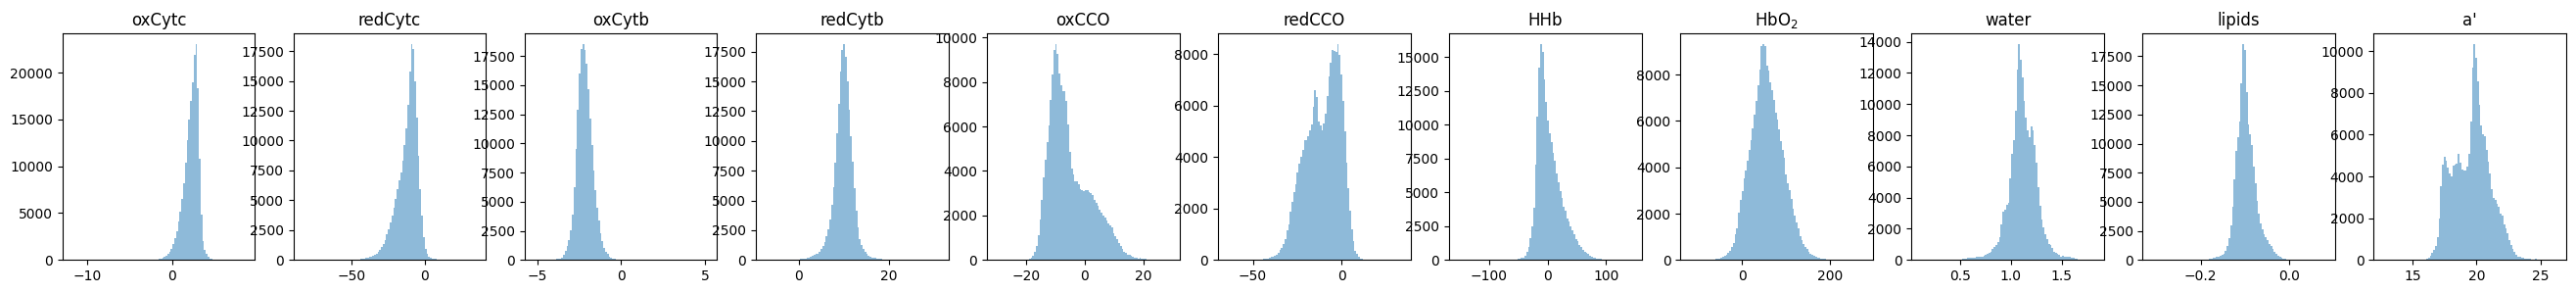

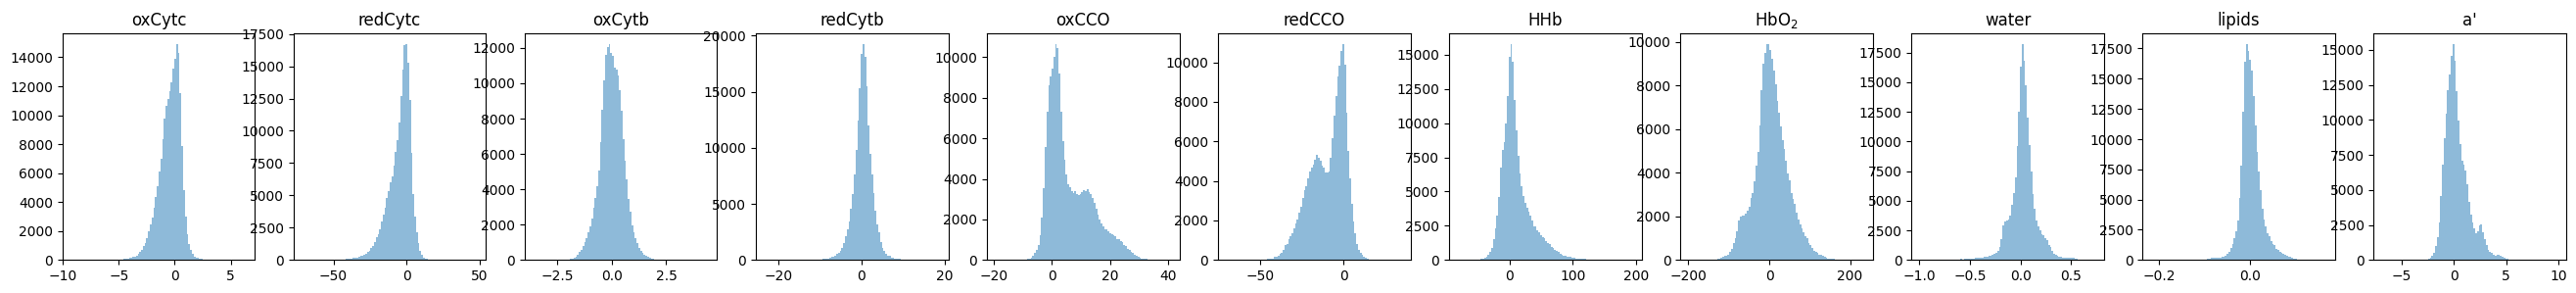

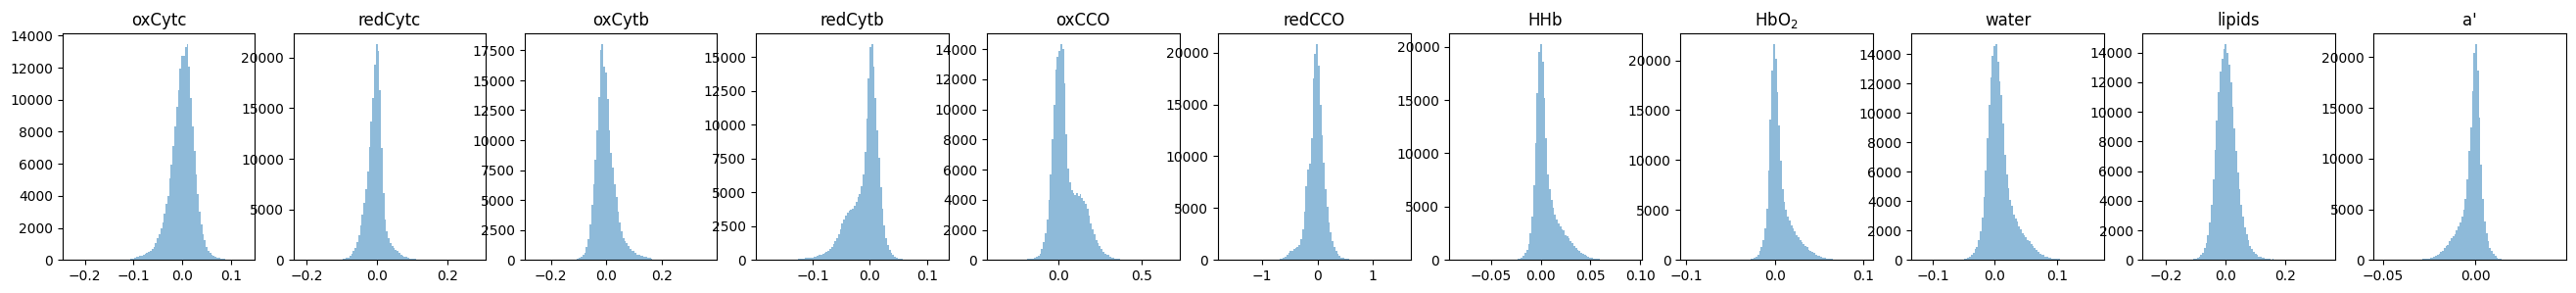

In [6]:
n = M_scatter_orig_smooth.shape[1]
l = diff_abs_data.shape[0]
heatmaps_osp = np.zeros((l,n))
for i in range(n):
    endmembers_remove = np.delete(M_scatter_orig_smooth, i, axis=1).T
    endmember_target = M_scatter_orig_smooth[:,i]
    heatmaps_osp[:,i] = osp(abs_data, endmembers_remove, endmember_target)
# heatmaps_osp, lower_clip_osp, upper_clip_osp, center_osp = clip_rescale(heatmaps_osp)
plot_map_dist(heatmaps_osp, endmember_labels)
np.save(folder + "heatmaps_osp.npy", heatmaps_osp)

n = M_scatter_orig_smooth.shape[1]
l = diff_abs_data.shape[0]
heatmaps_osp_diff = np.zeros((l,n))
for i in range(n):
    endmembers_remove = np.delete(M_scatter_orig_smooth, i, axis=1).T
    endmember_target = M_scatter_orig_smooth[:,i]
    heatmaps_osp_diff[:,i] = osp(diff_abs_data, endmembers_remove, endmember_target)
# heatmaps_osp_diff, lower_clip_osp_diff, upper_clip_osp_diff, center_osp_diff = clip_rescale(heatmaps_osp_diff)
plot_map_dist(heatmaps_osp_diff, endmember_labels)
np.save(folder + "heatmaps_osp_diff.npy", heatmaps_osp_diff)

n = M_mc_smooth.shape[1]
l = diff_abs_data.shape[0]
heatmaps_osp_diff_mc = np.zeros((l,n))
for i in range(n):
    endmembers_remove = np.delete(M_mc_smooth, i, axis=1).T
    endmember_target = M_mc_smooth[:,i]
    heatmaps_osp_diff_mc[:,i] = osp(diff_abs_data, endmembers_remove, endmember_target)
# heatmaps_osp_diff_mc, lower_clip_osp_diff_mc, upper_clip_osp_diff_mc, center_osp_diff_mc = clip_rescale(heatmaps_osp_diff_mc)
plot_map_dist(heatmaps_osp_diff_mc, endmember_labels)
np.save(folder + "heatmaps_osp_diff_mc.npy", heatmaps_osp_diff_mc)

### CEM

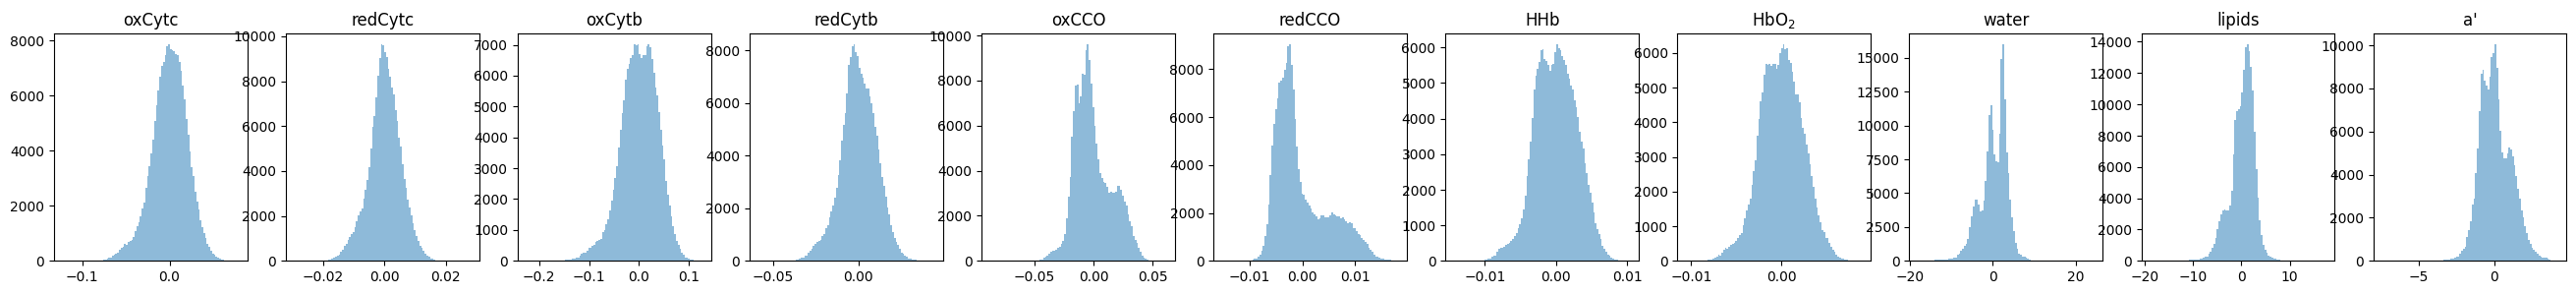

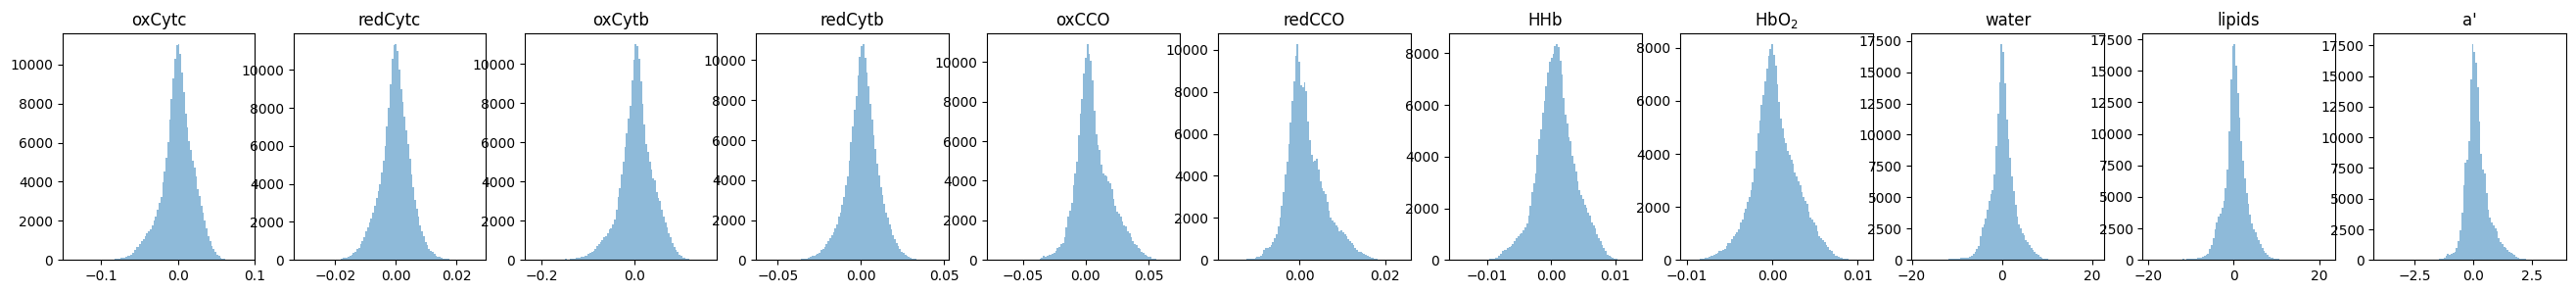

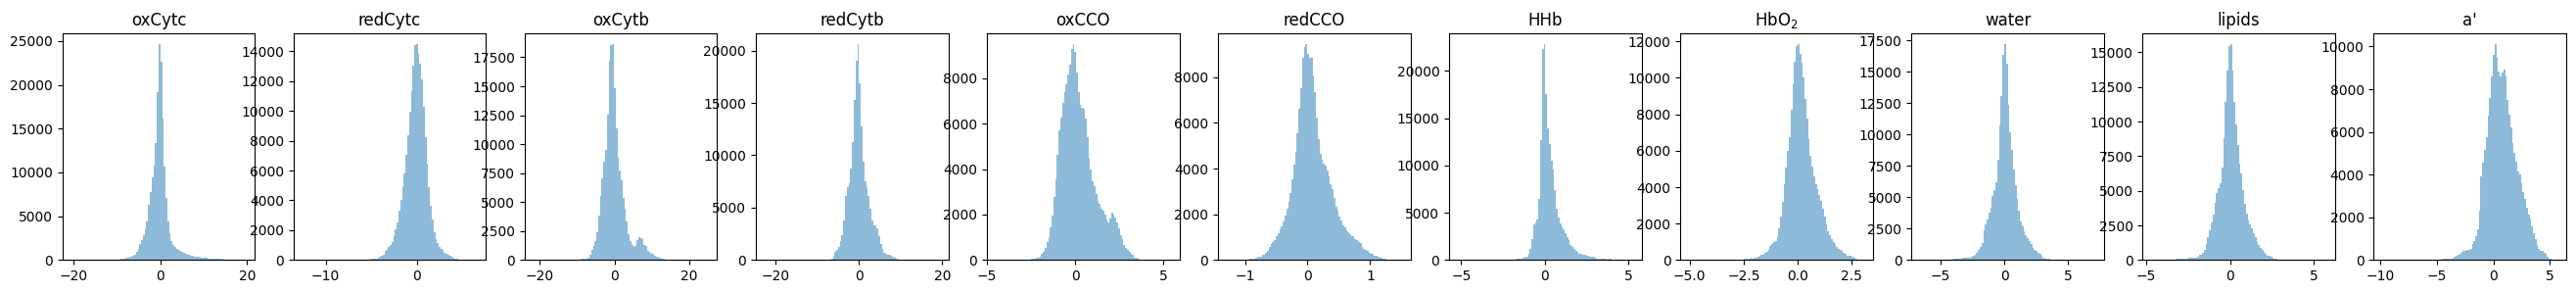

In [9]:
n = M_scatter_orig_smooth.shape[1]
l = diff_abs_data.shape[0]
heatmaps_icem = np.zeros((l,n))
for i in range(n):
    endmember_target = M_scatter_orig_smooth[:,i]
    heatmaps_icem[:,i], Rinv_abs = icem(abs_data, endmember_target, 1)
# heatmaps_icem, lower_clip_icem, upper_clip_icem, center_icem = clip_rescale(heatmaps_icem)
plot_map_dist(heatmaps_icem, endmember_labels)
np.save(folder + "heatmaps_icem.npy", heatmaps_icem)

n = M_scatter_orig_smooth.shape[1]
l = diff_abs_data.shape[0]
heatmaps_icem_diff = np.zeros((l,n))
for i in range(n):
    endmember_target = M_scatter_orig_smooth[:,i]
    heatmaps_icem_diff[:,i], Rinv_diff_abs = icem(diff_abs_data, endmember_target, 1)
# heatmaps_icem_diff, lower_clip_icem_diff, upper_clip_icem_diff, center_icem_diff = clip_rescale(heatmaps_icem_diff)
plot_map_dist(heatmaps_icem_diff, endmember_labels)
np.save(folder + "heatmaps_icem_diff.npy", heatmaps_icem_diff)

n = M_mc_smooth.shape[1]
l = abs_data.shape[0]
heatmaps_icem_diff_mc = np.zeros((l,n))
for i in range(n):
    endmember_target = M_mc_smooth[:,i]
    heatmaps_icem_diff_mc[:,i], _ = icem(diff_abs_data, endmember_target, 1)
# heatmaps_icem_diff_mc, lower_clip_icem_diff_mc, upper_clip_icem_diff_mc, center_icem_diff_mc = clip_rescale(heatmaps_icem_diff_mc)
plot_map_dist(heatmaps_icem_diff_mc, endmember_labels)
np.save(folder + "heatmaps_icem_diff_mc.npy", heatmaps_icem_diff_mc)

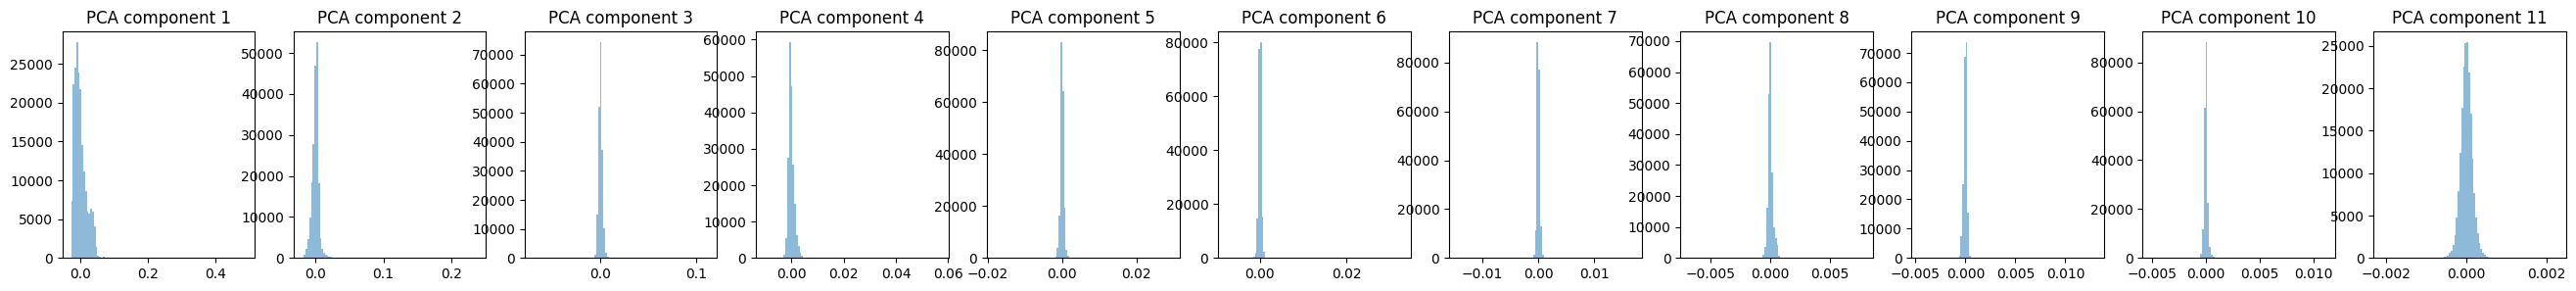

In [10]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(11)
pca_data = pca.fit_transform(preprocessed_data)
# pca_data, lower_clip_pca, upper_clip_pca, center_pca = clip_rescale(pca_data)
plot_map_dist(pca_data, [f"PCA component {i}" for i in range(1,12)])
np.save(folder + "pca_data.npy", pca_data)

### Test image

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


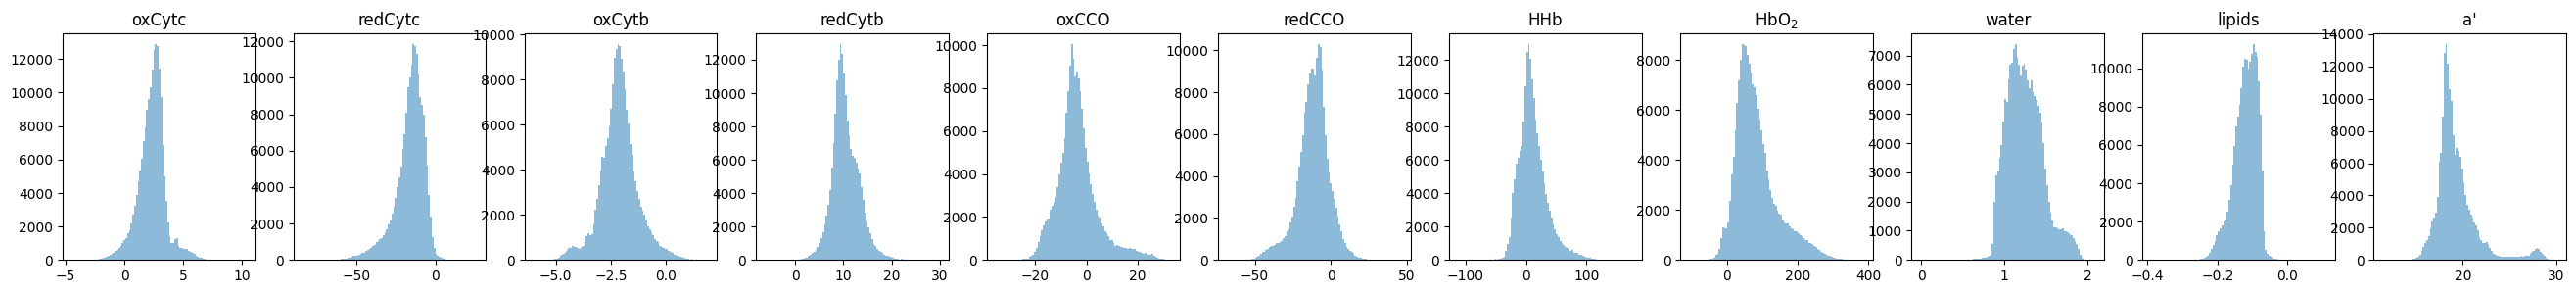

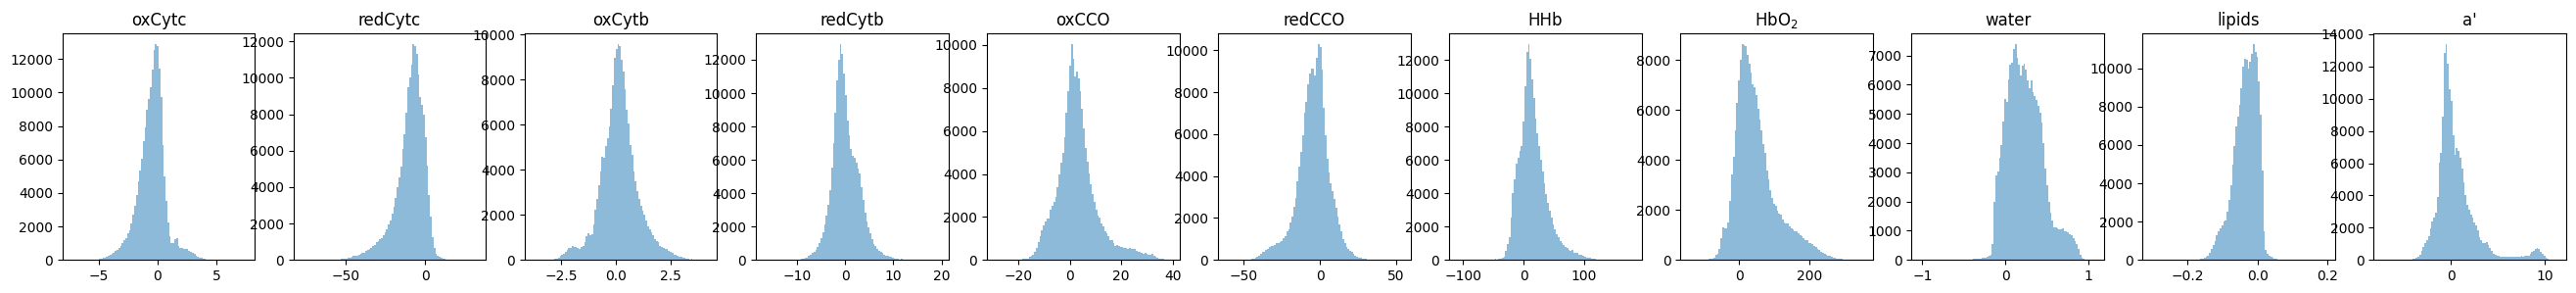

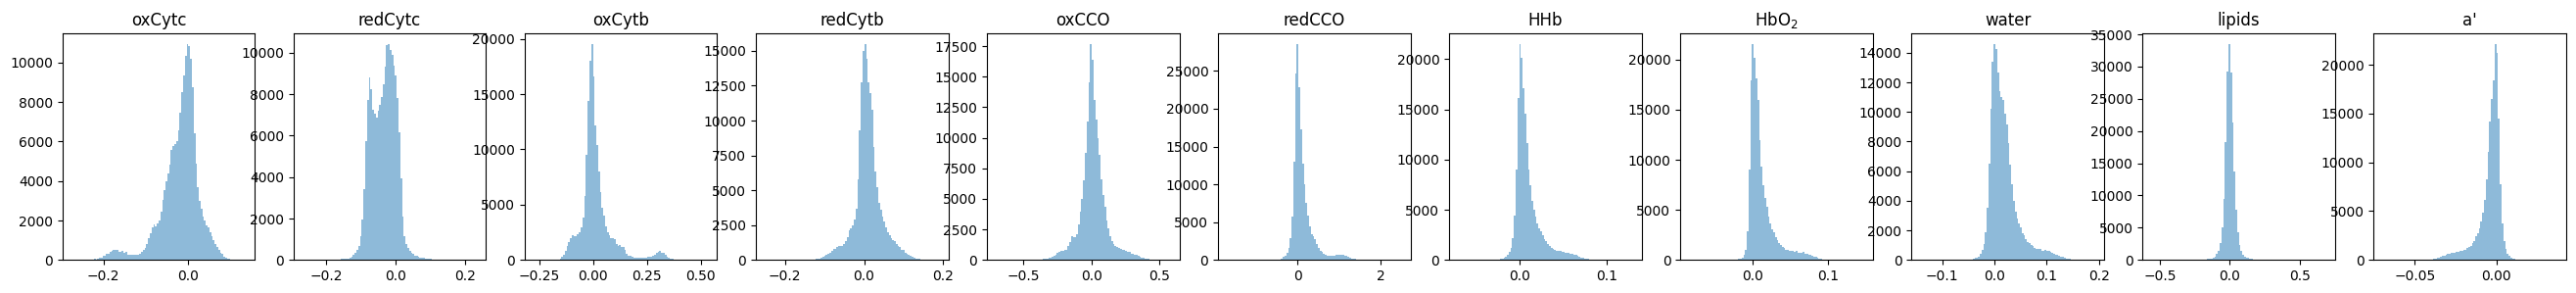

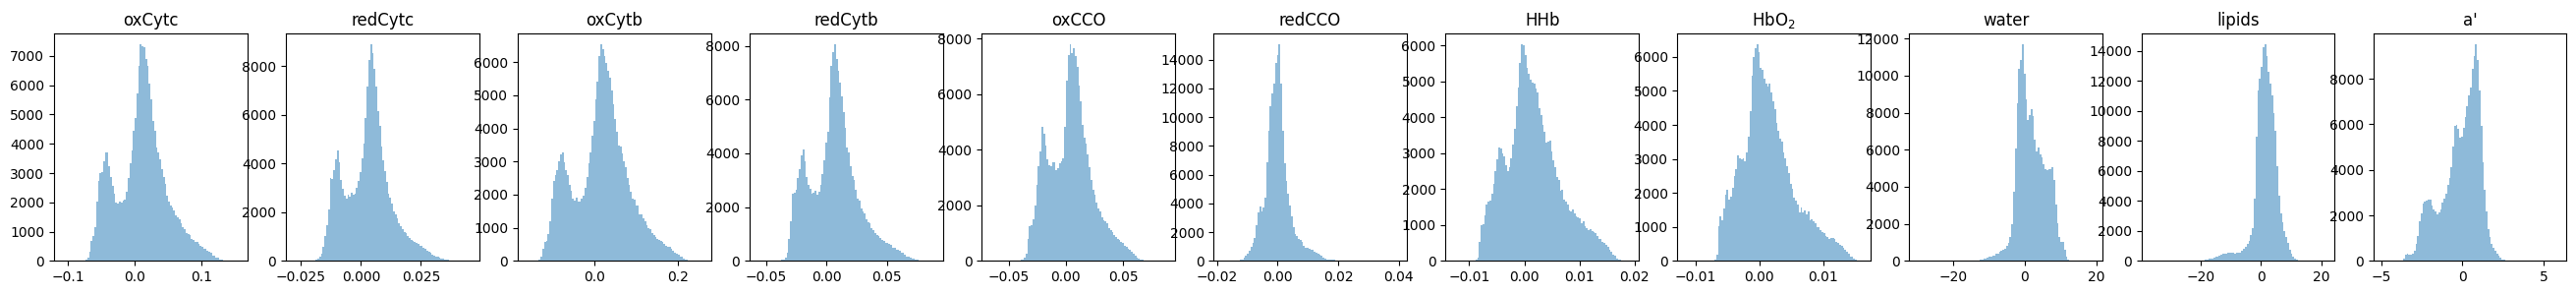

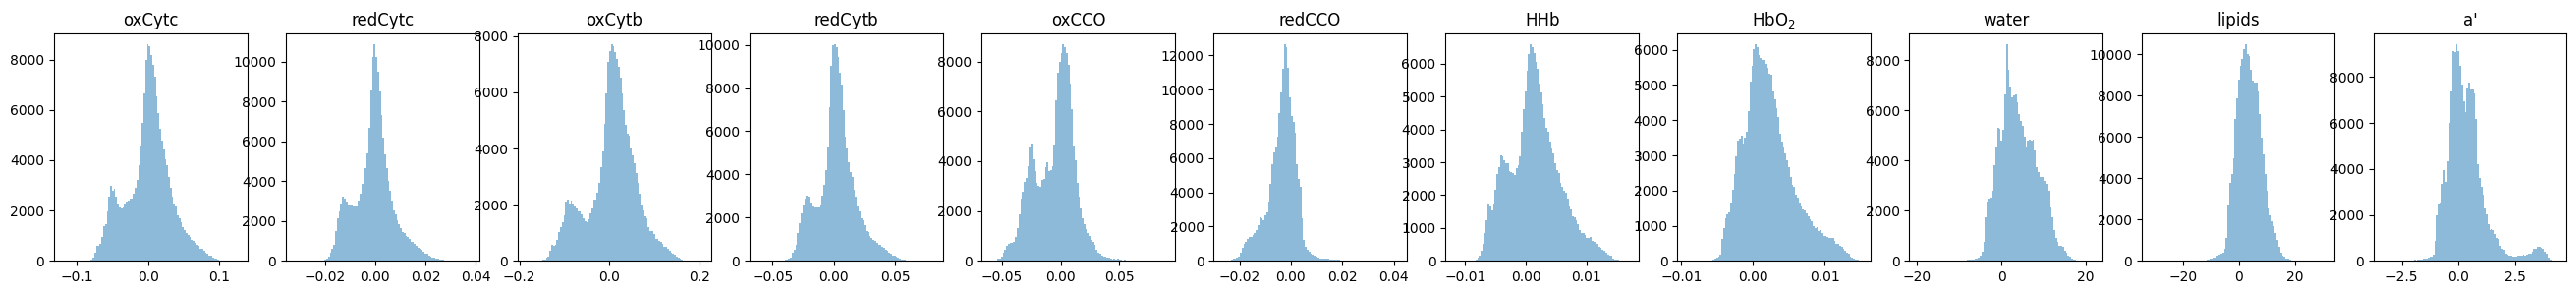

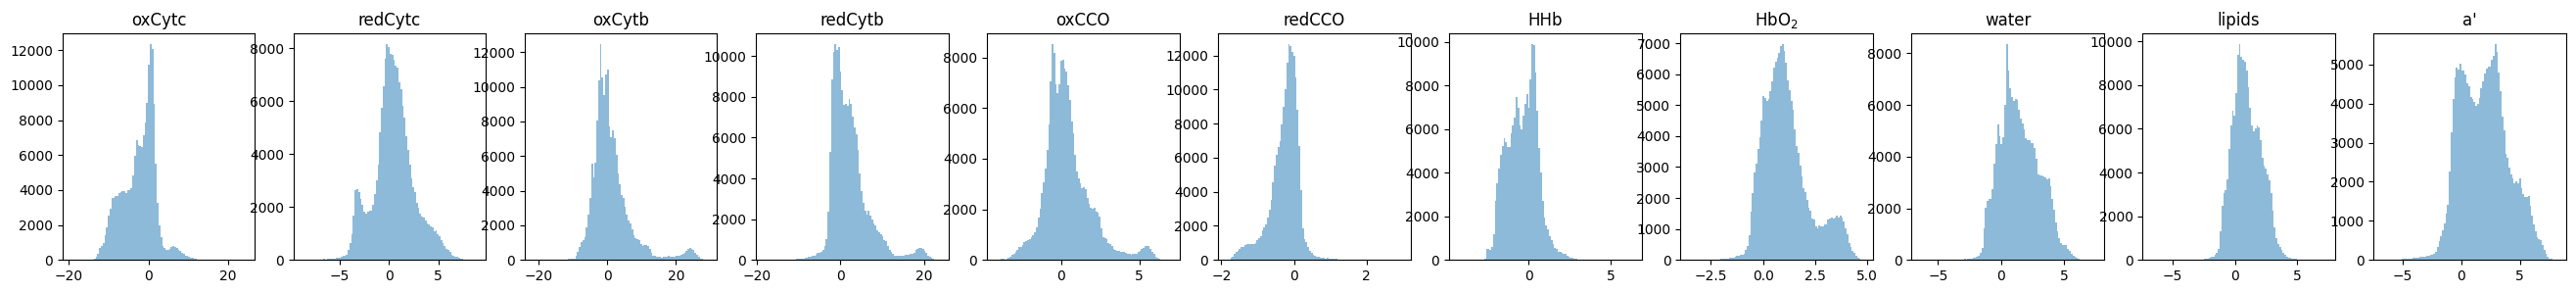

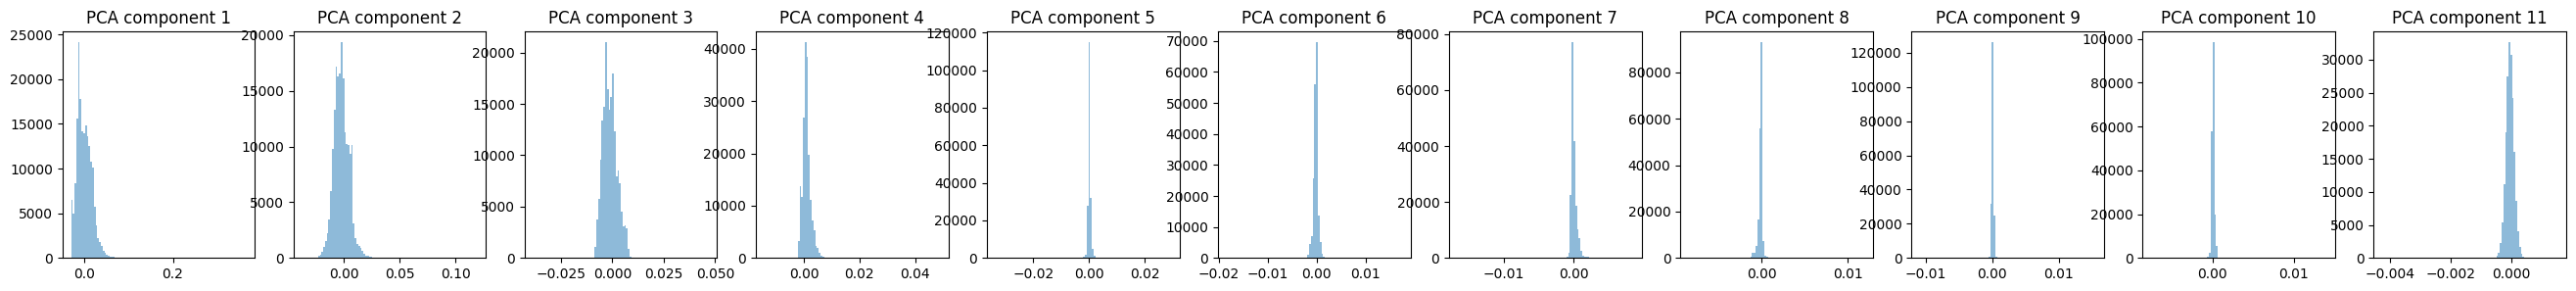

In [11]:
data_folder = f"../../datasets/helicoid/039-01"

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr").asarray()

# preprocessing
img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=(0,1), ord=1, keepdims=True)
img_smooth = smooth_spectral(img_calib_norm, 5)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

# select random spectrum from normal class
np.random.seed(1)
normal_idx = np.argwhere(gt_map == 1)
random_idx = np.random.choice(normal_idx.shape[0])
reference_spectrum = absorbance[normal_idx[random_idx,0], normal_idx[random_idx,1], :]

# calculate absorbance difference between the selected spectrum and the rest of the image
delta_absorbance = absorbance - reference_spectrum[None,None,:]

k = delta_absorbance.shape[-1]
raw_data = img_interp.reshape(-1, k)
preprocessed_data = img_smooth.reshape(-1, k)
abs_data = -np.log(preprocessed_data - np.min(preprocessed_data.flatten()) + 1e-8)
diff_abs_data = delta_absorbance.reshape(-1, k)
# convert gtmap to int32 format
labels_data = gt_map.squeeze().reshape(-1, 1).astype(np.int32)

folder = "./039-01/"

np.save(folder + "raw_data.npy", raw_data)
np.save(folder + "preprocessed_data.npy", preprocessed_data)
np.save(folder + "diff_abs_data.npy", diff_abs_data)
np.save(folder + "img_shape.npy", img_interp.shape[:2])
np.save(folder + "labels_data.npy", labels_data)

n = M_scatter_orig_smooth.shape[1]
l = diff_abs_data.shape[0]
heatmaps_osp = np.zeros((l,n))
for i in range(n):
    endmembers_remove = np.delete(M_scatter_orig_smooth, i, axis=1).T
    endmember_target = M_scatter_orig_smooth[:,i]
    heatmaps_osp[:,i] = osp(abs_data, endmembers_remove, endmember_target)
# heatmaps_osp, _, _, _ = clip_rescale(heatmaps_osp, lower_clip_osp, upper_clip_osp, center_osp)
plot_map_dist(heatmaps_osp, endmember_labels)
np.save(folder + "heatmaps_osp.npy", heatmaps_osp)

n = M_scatter_orig_smooth.shape[1]
l = diff_abs_data.shape[0]
heatmaps_osp_diff = np.zeros((l,n))
for i in range(n):
    endmembers_remove = np.delete(M_scatter_orig_smooth, i, axis=1).T
    endmember_target = M_scatter_orig_smooth[:,i]
    heatmaps_osp_diff[:,i] = osp(diff_abs_data, endmembers_remove, endmember_target)
# heatmaps_osp_diff, _, _, _ = clip_rescale(heatmaps_osp_diff, lower_clip_osp_diff, upper_clip_osp_diff, center_osp_diff)
plot_map_dist(heatmaps_osp_diff, endmember_labels)
np.save(folder + "heatmaps_osp_diff.npy", heatmaps_osp_diff)

n = M_mc_smooth.shape[1]
l = diff_abs_data.shape[0]
heatmaps_osp_diff_mc = np.zeros((l,n))
for i in range(n):
    endmembers_remove = np.delete(M_mc_smooth, i, axis=1).T
    endmember_target = M_mc_smooth[:,i]
    heatmaps_osp_diff_mc[:,i] = osp(diff_abs_data, endmembers_remove, endmember_target)
# heatmaps_osp_diff_mc, _, _, _ = clip_rescale(heatmaps_osp_diff_mc, lower_clip_osp_diff_mc, upper_clip_osp_diff_mc, center_osp_diff_mc)
plot_map_dist(heatmaps_osp_diff_mc, endmember_labels)
np.save(folder + "heatmaps_osp_diff_mc.npy", heatmaps_osp_diff_mc)

n = M_scatter_orig_smooth.shape[1]
l = diff_abs_data.shape[0]
heatmaps_icem = np.zeros((l,n))
for i in range(n):
    endmember_target = M_scatter_orig_smooth[:,i]
    heatmaps_icem[:,i], _ = icem(abs_data, endmember_target, 1, Rinv=Rinv_abs)
# heatmaps_icem, _, _, _ = clip_rescale(heatmaps_icem, lower_clip_icem, upper_clip_icem, center_icem)
plot_map_dist(heatmaps_icem, endmember_labels)
np.save(folder + "heatmaps_icem.npy", heatmaps_icem)

n = M_scatter_orig_smooth.shape[1]
l = diff_abs_data.shape[0]
heatmaps_icem_diff = np.zeros((l,n))
for i in range(n):
    endmember_target = M_scatter_orig_smooth[:,i]
    heatmaps_icem_diff[:,i], _ = icem(diff_abs_data, endmember_target, 1, Rinv=Rinv_diff_abs)
# heatmaps_icem_diff, _, _, _ = clip_rescale(heatmaps_icem_diff, lower_clip_icem_diff, upper_clip_icem_diff, center_icem_diff)
plot_map_dist(heatmaps_icem_diff, endmember_labels)
np.save(folder + "heatmaps_icem_diff.npy", heatmaps_icem_diff)

n = M_mc_smooth.shape[1]
l = abs_data.shape[0]
heatmaps_icem_diff_mc = np.zeros((l,n))
for i in range(n):
    endmember_target = M_mc_smooth[:,i]
    heatmaps_icem_diff_mc[:,i], _ = icem(diff_abs_data, endmember_target, 1, Rinv=Rinv_diff_abs)
# heatmaps_icem_diff_mc, _, _, _ = clip_rescale(heatmaps_icem_diff_mc, lower_clip_icem_diff_mc, upper_clip_icem_diff_mc, center_icem_diff_mc)
plot_map_dist(heatmaps_icem_diff_mc, endmember_labels)
np.save(folder + "heatmaps_icem_diff_mc.npy", heatmaps_icem_diff_mc)

pca_data = pca.transform(preprocessed_data)
# pca_data, _, _, _ = clip_rescale(pca_data, lower_clip_pca, upper_clip_pca, center_pca)
plot_map_dist(pca_data, [f"PCA component {i}" for i in range(1,12)])
np.save(folder + "pca_data.npy", pca_data)